# Detection with SSD

In this example, we will load a SSD model and use it to detect objects.

### 1. Setup

* First, Load necessary libs and set up caffe and caffe_root

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make sure that caffe is on the python path:
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import os
os.chdir(caffe_root)
import sys
sys.path.insert(0, 'python')

import caffe
caffe.set_device(0)
caffe.set_mode_gpu()

* Load LabelMap.

In [2]:
from google.protobuf import text_format
from caffe.proto import caffe_pb2

# load PASCAL VOC labels
labelmap_file = 'data/VOC0712/labelmap_voc.prototxt'
file = open(labelmap_file, 'r')
labelmap = caffe_pb2.LabelMap()
text_format.Merge(str(file.read()), labelmap)

def get_labelname(labelmap, labels):
    num_labels = len(labelmap.item)
    labelnames = []
    if type(labels) is not list:
        labels = [labels]
    for label in labels:
        found = False
        for i in xrange(0, num_labels):
            if label == labelmap.item[i].label:
                found = True
                labelnames.append(labelmap.item[i].display_name)
                break
        assert found == True
    return labelnames

* Load the net in the test phase for inference, and configure input preprocessing.

In [3]:
model_def = 'models/VGGNet/VOC0712/SSD_512x512_coco/deploy.prototxt'
model_weights = 'models/VGGNet/VOC0712/SSD_512x512_coco/VGG_coco_SSD_512x512.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([104,117,123])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

### 2. SSD detection

* Load an image.

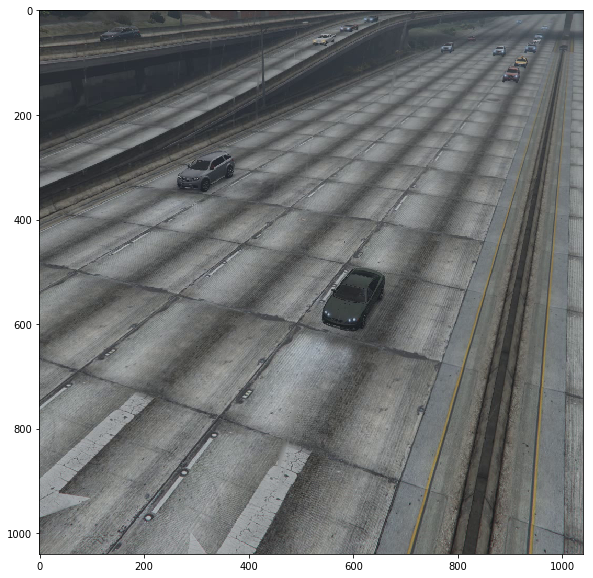

In [5]:
## set net to batch size of 1
image_resize = 512
net.blobs['data'].reshape(1,3,image_resize,image_resize)

ima_name = '00090.png'

image = caffe.io.load_image('examples/images/202/' + ima_name)
height = image.shape[0]
width = image.shape[1]
image = image[:,(-height + width) / 2 : (height + width) / 2 ]
image = image[300:-100, 200:-200]
plt.imshow(image)

* Run the net and examine the top_k results

In [6]:
transformed_image = transformer.preprocess('data', image)
net.blobs['data'].data[...] = transformed_image

# Forward pass.
detections = net.forward()['detection_out']

# Parse the outputs.
det_label = detections[0,0,:,1]
det_conf = detections[0,0,:,2]
det_xmin = detections[0,0,:,3]
det_ymin = detections[0,0,:,4]
det_xmax = detections[0,0,:,5]
det_ymax = detections[0,0,:,6]

# Get detections with confidence higher than 0.6.
top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.15]

top_conf = det_conf[top_indices]
top_label_indices = det_label[top_indices].tolist()
top_labels = get_labelname(labelmap, top_label_indices)
top_xmin = det_xmin[top_indices]
top_ymin = det_ymin[top_indices]
top_xmax = det_xmax[top_indices]
top_ymax = det_ymax[top_indices]

* Plot the boxes

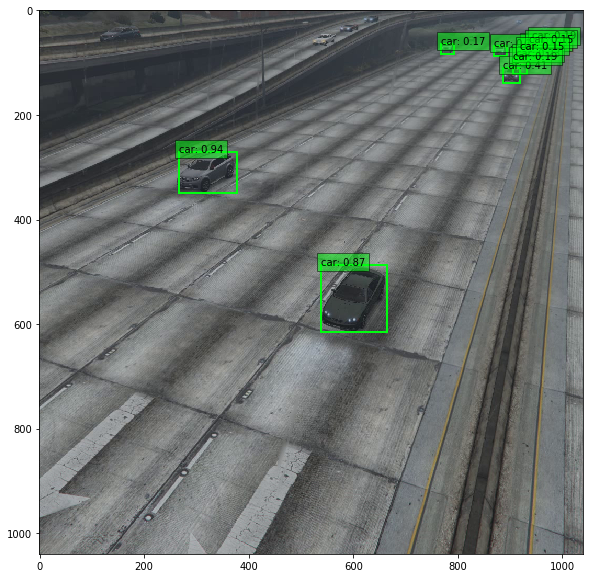

In [7]:
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

plt.imshow(image)
currentAxis = plt.gca()

for i in xrange(top_conf.shape[0]):
    if top_labels[i] == u'car' or top_labels[i] == u'bus':
        xmin = int(round(top_xmin[i] * image.shape[1]))
        ymin = int(round(top_ymin[i] * image.shape[0]))
        xmax = int(round(top_xmax[i] * image.shape[1]))
        ymax = int(round(top_ymax[i] * image.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = top_labels[i]
        display_txt = '%s: %.2f'%(label_name, score)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})

In [8]:
def crop_image_coor(image_raw, image, starti, startj, length):
    image = image[starti:(starti + length), startj:(startj + length)]
    transformed_image = transformer.preprocess('data', image)
    net.blobs['data'].data[...] = transformed_image
    # Forward pass.
    detections = net.forward()['detection_out']

    # Parse the outputs.
    det_label = detections[0,0,:,1]
    det_conf = detections[0,0,:,2]
    det_xmin = detections[0,0,:,3]
    det_ymin = detections[0,0,:,4]
    det_xmax = detections[0,0,:,5]
    det_ymax = detections[0,0,:,6]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.15]
    
    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_labels = get_labelname(labelmap, top_label_indices)
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]
    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.imshow(image)
    currentAxis = plt.gca()
    
    return ((top_xmin * image.shape[1])) + startj, ((top_ymin * image.shape[1])) + starti, ((top_xmax * image.shape[1])) + startj, ((top_ymax * image.shape[1])) + starti, top_conf, top_label_indices, top_labels

In [9]:
def eachFile(filepath):
    pathDir =  os.listdir(filepath)
#     print len(pathDir)
#     for allDir in pathDir:
#         child = os.path.join('%s%s' % (filepath, allDir))
    return len(pathDir)
        #print child

In [10]:
image_resize = 512
net.blobs['data'].reshape(1,3,image_resize,image_resize)
folder_dir = 'examples/images/202/'

f1 = open(folder_dir + 'dec.txt','w')
f1.write('')
f1.close()

num_of_ima = eachFile(folder_dir)

for frame in range(num_of_ima - 2):
    plt.rcParams['figure.figsize'] = (10, 10)
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'
    ima_num = '%05d' %(frame + 1)
    ima_name = ima_num + '.png'
    if frame % 100 == 0:
        print ima_name
    image = caffe.io.load_image(folder_dir + ima_name)
    image_raw = image
    top_xmin1, top_ymin1, top_xmax1, top_ymax1, top_conf1, top_label_indices1, top_labels1 = crop_image_coor(image_raw, image, 540, 0, 900)
    top_xmin2, top_ymin2, top_xmax2, top_ymax2, top_conf2, top_label_indices2, top_labels2 = crop_image_coor(image_raw, image, 540, 700, 900)
#     top_xmin3, top_ymin3, top_xmax3, top_ymax3, top_conf3, top_label_indices3, top_labels3 = crop_image_coor(image_raw, image, 180, 760, 400)
    top_xmin = np.concatenate((top_xmin1, top_xmin2), axis = 0)
    top_ymin = np.concatenate((top_ymin1, top_ymin2), axis = 0)
    top_xmax = np.concatenate((top_xmax1, top_xmax2), axis = 0)
    top_ymax = np.concatenate((top_ymax1, top_ymax2), axis = 0)
    top_conf = np.concatenate((top_conf1, top_conf2), axis = 0)
    top_label_indices = top_label_indices1 + top_label_indices2
    top_labels = top_labels1 + top_labels2
    
    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    plt.imshow(image)
    currentAxis = plt.gca()

    for i in xrange(top_xmin.shape[0]):
        if top_labels[i] == u'car' or top_labels[i] == u'bus':
#             xmin = int(round(top_xmin[i] * image.shape[1]))
#             ymin = int(round(top_ymin[i] * image.shape[0]))
#             xmax = int(round(top_xmax[i] * image.shape[1]))
#             ymax = int(round(top_ymax[i] * image.shape[0]))
            xmin = top_xmin[i]
            ymin = top_ymin[i]
            xmax = top_xmax[i]
            ymax = top_ymax[i]
            score = top_conf[i]
            label = int(top_label_indices[i])
            temp_out = str(label) + ', ' + str(frame) + ', ' + str(xmin) + ', ' + str(ymin) + ', ' + str(xmax - xmin + 1) + ', ' + str(ymax - ymin + 1) + ', ' + str(score) + '\n'
            label_name = top_labels[i]
            display_txt = '%s: %.2f'%(label_name, score)
            coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
            color = colors[label]
            currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
            currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
            f2 = open(folder_dir + 'dec.txt','r+')
            f2.read()
            f2.write(temp_out)
            f2.close()
    plt.savefig(folder_dir + 'dec/' + ima_num + '.png')
    plt.close()


00001.png
00101.png
00201.png
00301.png
